# Recurrent Neural Network
## Classifier: Traffic as Low, Medium, or High

Import necessary modules.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

Load data from text file.

In [3]:
data = np.genfromtxt('/Users/mitch/Dropbox/FinalProject/traffic2.txt')

Define functions and derivatives of those functions to be used in the RNN.

In [4]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def relu(x):
    return np.maximum(x,np.zeros_like(x))

def Leaky_ReLU_deriv(x):
    dRLU = np.empty(len(x))
    for i in range(len(x)):
        if x[i] > 0: 
            dRLU[i] = 1
        else:
            dRLU[i] = 0.1
    return dRLU   

# Rename function for convenience
LRD = Leaky_ReLU_deriv

Define a recurrent neural network class, which repeats a single layer.

In [5]:
class OneLayerRNN:
    
    def __init__(self,hidden_units=10,output_units=3):
        self.V = None
        self.W = None
        self.h = None
        self.z = None
        self.hidden_units = hidden_units
        self.output_units = output_units
        self.windowlen = None
        self.futuretime = None
    
    def initialize(self,X):
        # Weight matrices start as normal distributions
        self.V = np.random.normal(scale=1.0/np.sqrt(self.hidden_units),size=((self.hidden_units),1))
        self.W = np.random.normal(scale=1.0/np.sqrt(self.hidden_units),size=(self.output_units,self.hidden_units))
        self.h = np.zeros((len(X),self.hidden_units))
        self.z = np.zeros((len(X),self.output_units))

        # Matrices for gradient update
        self.gV = np.zeros_like(self.V)
        self.gW = np.zeros_like(self.W)

        
    def forward(self,X):
        for i in range(len(X)):
            x = X[i]                                                        # traffic at time i
            
            self.h[i] = relu(np.dot(self.V,x)).flatten()        # calculate new layer output
            self.z[i] = sigmoid(np.dot(self.W,self.h[i]))
            
    def backward(self,X,y):
        """Backpropagation through time"""
        for i in range(len(X)):
            x = X[i]
            Q = self.z[i] - y
            self.gV += np.array([np.dot(self.W.T,Q)*LRD(self.h[i]*x)]).T
            self.gW += np.outer(Q,self.h[i])
            
    def update_VW(self,epsilon):
        """Update"""
        self.V = self.V - epsilon*self.gV
        self.W = self.W - epsilon*self.gW

    def one_hot_encode(self,occ):
        if occ < 0.33: return np.array([1,0,0])
        elif occ >= 0.33 and occ < 0.67: return np.array([0,1,0])
        elif occ >= 0.67: return np.array([0,0,1])
        else: print('Error: the given occupancy value was ',occ) 
            
            
    def train(self,timeframe,epsilon,windowlen=24,futuretime=0):
        """
        Train the neural network given input data as X
        X:   - a series of occupancies
        """
        self.windowlen=windowlen
        self.futuretime = futuretime
        
        windowstart = 0
        firstwindow = timeframe[:windowlen]
        self.initialize(firstwindow)
        counter,total = 0,0
        trainingerrors = []
        while windowstart < len(timeframe)-windowlen-futuretime-1:
            timewindow = timeframe[windowstart:windowstart+windowlen]
            timewindowlabel = self.one_hot_encode(timeframe[windowstart+windowlen+futuretime])
            trueforecast = np.argmax(timewindowlabel)
            
            self.forward(timewindow)
            self.backward(timewindow,timewindowlabel)
            self.update_VW(epsilon)
            
            prediction = np.argmax(np.average(self.z,axis=0))

            if prediction == trueforecast:
                counter += 1
            total += 1

            TE = counter/total
            if windowstart%1000==0:
                #print(windowstart,'\t',TE)
                trainingerrors.append(TE)
            windowstart=windowstart+1
        #print(counter/total)
        return trainingerrors
                
        
    def predict(self,timeframe,predicttime,predictgap=0):
        timewindow = timeframe[predicttime-predictgap-self.windowlen:predicttime-predictgap]
        self.forward(timewindow)
        classification = np.argmax(np.average(self.z,axis=0))
        '''if classification==0:
            print('low')
        elif classification==1:
            print('med')
        elif classification==2:
            print('high')'''
        
        return classification

    

Calculate the test error from each of 8 sensors for a set of 100 test points.

In [6]:
for sensor in range(8):
    RNN = OneLayerRNN()
    RNN.train(data[sensor,:60000],0.001)
    counter,total = 0,0
    for j in range(100): # loop over several test points
        predictpoint = 60000+25*j
        prediction = RNN.predict(data[sensor,60000:],predictpoint)
        truevalue = data[20,predictpoint]
        if prediction==np.argmax(RNN.one_hot_encode(truevalue)):
            counter += 1
        total += 1
    print(counter/total)

/Users/mitch/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.99
0.99
0.99
0.99
0.99
0.99
0.99
0.99


Train the neural network on the first 20 sensors. Save the training accuracies after each rolling window has been entirely calculated.

In [7]:
sensortrials = []
for i in range(20):
    timeframe = data[i,:60000]
    RNN = OneLayerRNN()
    print('Sensor',i)
    trainingerrors=RNN.train(timeframe,0.001)
    sensortrials.append(trainingerrors)
    # predict statement

Sensor 0


/Users/mitch/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Sensor 1
Sensor 2
Sensor 3
Sensor 4
Sensor 5
Sensor 6
Sensor 7
Sensor 8
Sensor 9
Sensor 10
Sensor 11
Sensor 12
Sensor 13
Sensor 14
Sensor 15
Sensor 16
Sensor 17
Sensor 18
Sensor 19


In [8]:
RNN.predict(timeframe,60100)

0

Plot the training errors for each sensor.

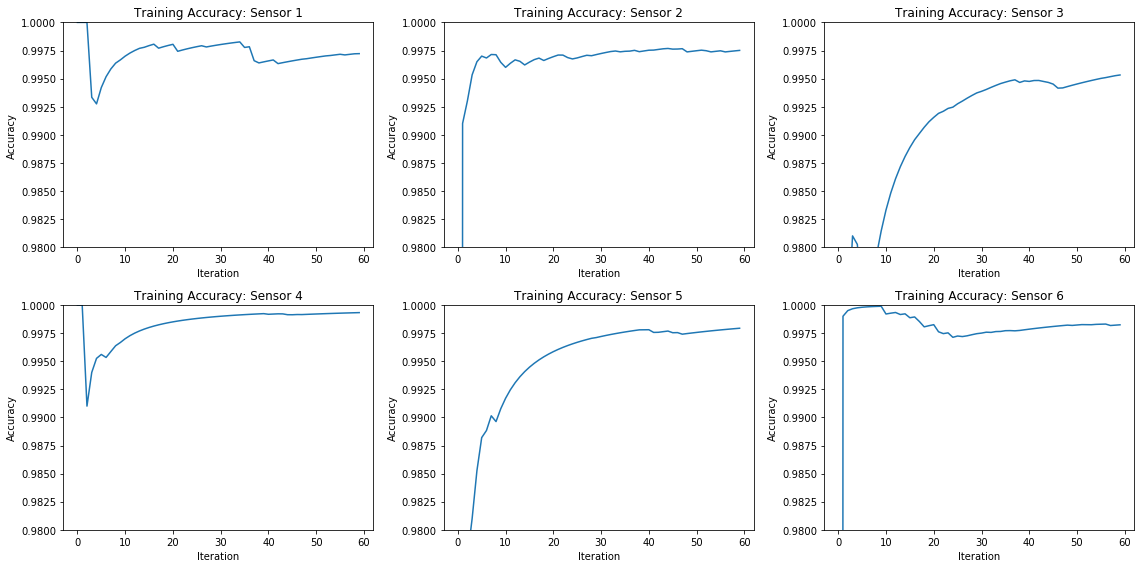

In [9]:
fig = plt.figure(figsize=(16,8))
for i in range(6):
    fig.add_subplot(2,3,i+1)
    plt.plot(sensortrials[i])
    plt.ylim(0.98,1.00)
    plt.tight_layout()
    plt.title('Training Accuracy: Sensor '+str(i+1))
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
plt.show()
plt.savefig('train_acc_10hu.jpg')

